In [1]:
import numpy
from matplotlib import pyplot

from bayes_opt.acquisition import Acquisition
from bayes_opt.basic.cov_func import SquaredExponential
from bayes_opt.basic.gaussian_process import GaussianProcess
from bayes_opt.bayesian_optimization import BayesianOptimization

%matplotlib inline


## Target function

create a target 1-D function with multiple local maxima to test and visualize
how the gaussian processes work.

The target function we will try to maximize is the following:

$$f(x) =e^{-(x-2)^2} + e^{-\frac{(x-6)^2}{10}} + \frac{1}{x^2+1}$$

In practice, the function is unknown, the only information we have is obtained by sequentially probing it at different points.

Based on Gaussian process, we can construct a posterior distribution of functions that best fit the observed data.

In [2]:
def target(x):
    return numpy.exp(-(x - 2)**2) + numpy.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

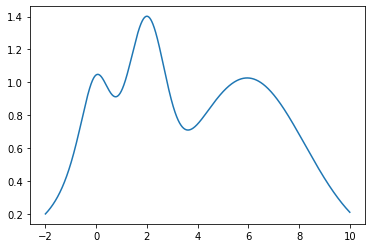

In [3]:
x = numpy.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)

pyplot.plot(x, y)

## bayesian optimization

#### gaussian process example visualization for 1d data

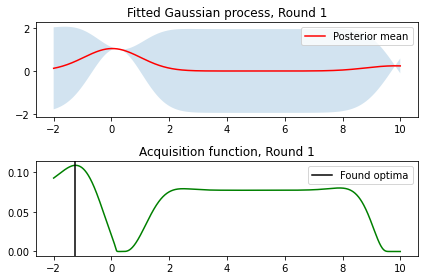

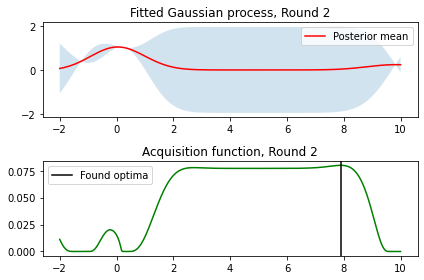

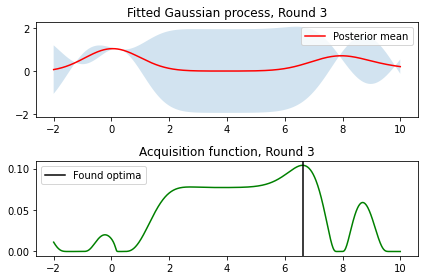

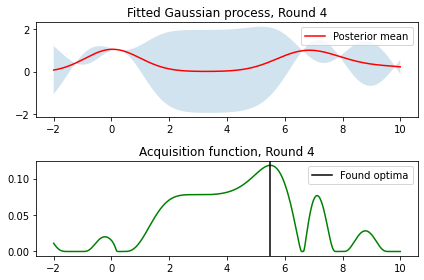

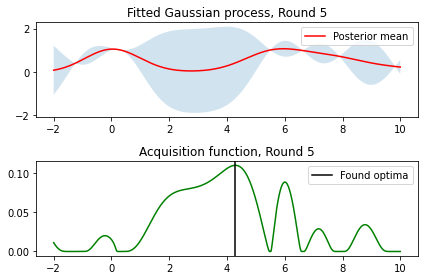

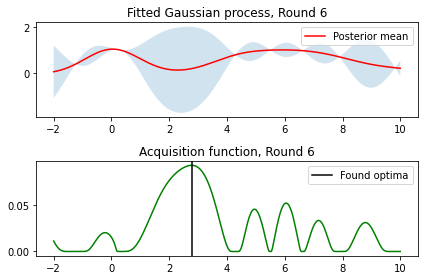

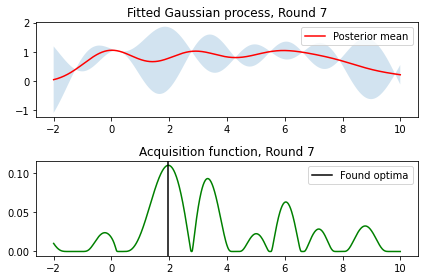

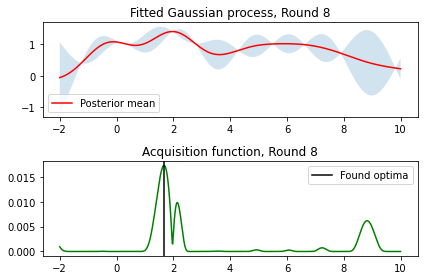

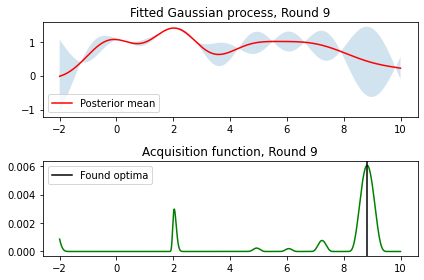

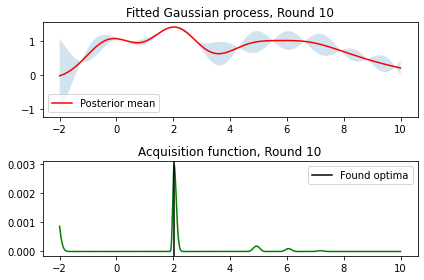

In [4]:
def plot_gp(bayes_opt, param, i):
    param_value = list(param.values())[0][1]
    x_test = numpy.linspace(param_value[0], param_value[1], 1000).reshape(1000, 1)
    hat = bayes_opt.gp.predict(x_test, return_std=True)
    y_hat, y_std = hat[0], numpy.sqrt(hat[1])
    lower, upper = y_hat - 1.96 * y_std, y_hat + 1.96 * y_std

    fig = pyplot.figure()
    r = fig.add_subplot(2, 1, 1)
    r.set_title('Fitted Gaussian process, Round {i}'.format(i=i))
    pyplot.fill_between(x_test.flatten(), lower, upper, alpha=0.2)
    pyplot.plot(x_test.flatten(), y_hat, color='red', label="Posterior mean")
    pyplot.legend(loc=0)

    a = numpy.array([-bayes_opt._acq_wrapper(numpy.atleast_1d(x)) for x in x_test]).flatten()
    r = fig.add_subplot(2, 1, 2)
    r.set_title('Acquisition function, Round {i}'.format(i=i))
    pyplot.plot(x_test, a, color='green')
    bayes_opt._optimize_acq(method='L-BFGS-B', n_start=1000)
    pyplot.axvline(x=bayes_opt.best, color='black', label='Found optima')
    pyplot.legend(loc=0)
    pyplot.tight_layout()


cov_func = SquaredExponential()
gp = GaussianProcess(cov_func=cov_func)
acq = Acquisition(mode="ExpectedImprovement")
param = {'x': ('cont', [-2, 10])}

bayes_opt = BayesianOptimization(gp, acq, func=target, param_dict=param, n_job=1)
bayes_opt._first_run()

for i in range(10):
    plot_gp(bayes_opt, param, i+1)
    bayes_opt.update_gp()